# Vehicle Image Processing

In this notebook the vehicle image pixel intensity is analysed. 

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from glob import glob
from scipy.misc import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

At first we load the data set and extract the training data. 

In [77]:
with open('../data/data.p', 'rb') as f:
    data = pickle.load(f)
    
X_train, y_train = data['train']

print('Length X_train', len(X_train))
print('Length y_train', len(y_train))

Length X_train 20574
Length y_train 20574


Then we plot the average pixel intensity of all color channels. The images are also cropped since in most cases
the car is only in the center are of the image.

The plot shows that most images have an average intensity around 50 which might explain why the classifier
has trouble with light colors and white..

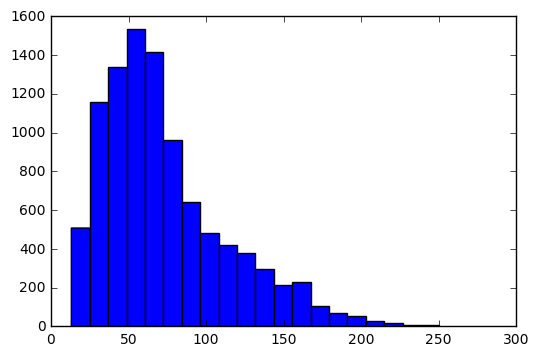

In [76]:
cars = X_train[y_train==1]
_ = plt.hist(np.mean(cars[:, 16:48, 16:48], axis=(1,2,3)), bins=20)

In [85]:
print('mean:', np.mean(cars[:, 16:48, 16:48], axis=(1,2,3)).mean())
print('std:', np.mean(cars[:, 16:48, 16:48], axis=(1,2,3)).std())

mean: 73.2404443991
std: 40.2780620606


Now all images with an intesnsity higher 110 are selected. The threshold was chose to be the mean plus one time the standard deviation of the destribution.

In [81]:
wht_filter = np.mean(cars[:, 16:48, 16:48], axis=(1,2,3)) > 110

The selected images are then fed into an ImageDataGenerator from the Keras library which allows for an easy augumentation. This way the additionally added images won't be identical. Also some examples are displayed.

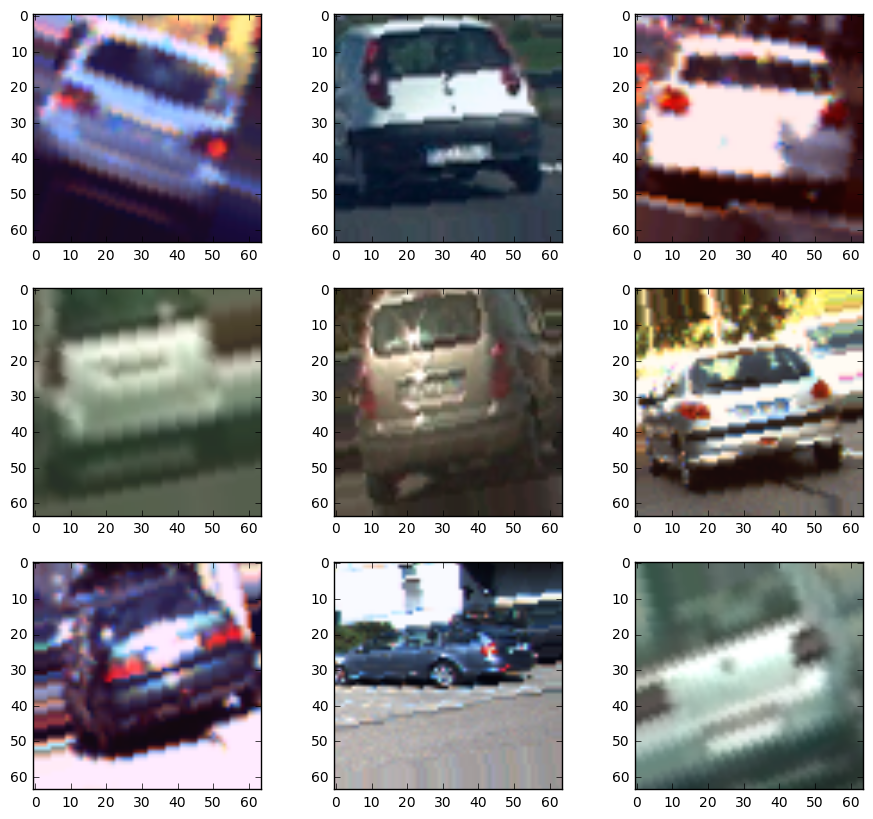

In [86]:
idg = ImageDataGenerator(
    rotation_range=20.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    channel_shift_range=20,
    horizontal_flip=True)

fig, axis = plt.subplots(3,3, figsize=(11,10))
for i, (x,y) in enumerate(idg.flow(cars[wht_filter], np.ones(len(cars[wht_filter])), batch_size=1)):
    if i == 9: break
    axis[i%3, i//3].imshow(x[0].astype(np.uint8))

In the following cell, 2500 (100 * 25) new images will be created and added to the original data set

In [83]:
BATCH_SIZE = 100
BATCHES = 25

for i, (x,y) in enumerate(idg.flow(cars[wht_filter], np.ones(len(cars[wht_filter])), batch_size=BATCH_SIZE)):
    if i == BATCHES: break
        
    X_train = np.concatenate((X_train, x.astype(np.uint8)), axis=0)
    y_train = np.concatenate((y_train, y.astype(np.uint8)), axis=0)

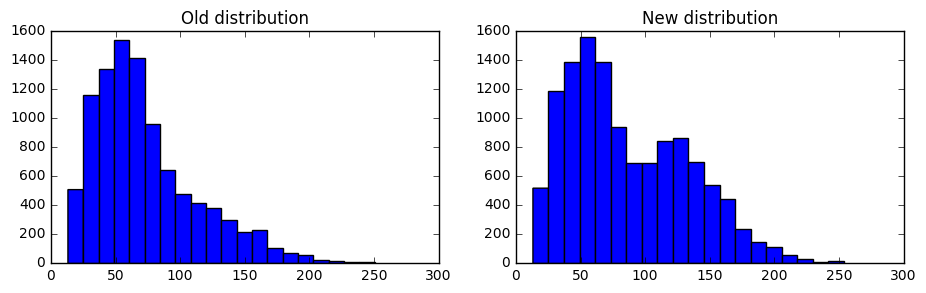

In [90]:
cars_new = X_train[y_train==1]

fig, axis = plt.subplots(1,2, figsize=(11,3))
_ = axis[0].hist(np.mean(cars[:, 16:48, 16:48], axis=(1,2,3)), bins=20)
_ = axis[0].set_title('Old distribution')

_ = axis[1].hist(np.mean(cars_new[:, 16:48, 16:48], axis=(1,2,3)), bins=20)
_ = axis[1].set_title('New distribution')


The distribution is more balanced now.

In [91]:
print('Length X_train', len(X_train))
print('Length y_train', len(y_train))

Length X_train 23053
Length y_train 23053


In [92]:
data['train'] = (X_train, y_train)

with open('../data/data_adj.p', 'wb') as f:
    pickle.dump(data, f)